Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint,EarlyStopping

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("data/Train")
data_dir_test = pathlib.Path("data/Test")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds =  tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  batch_size=batch_size,
  image_size=(180,180),
  label_mode='categorical',
  seed=123,
)

Found 15739 files belonging to 9 classes.


2024-08-07 22:26:48.762949: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-08-07 22:26:48.762975: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-08-07 22:26:48.762984: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-08-07 22:26:48.763002: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-07 22:26:48.763015: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  batch_size=batch_size,
  image_size=(180,180),
  label_mode='categorical',
  seed=123,
)

Found 118 files belonging to 9 classes.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

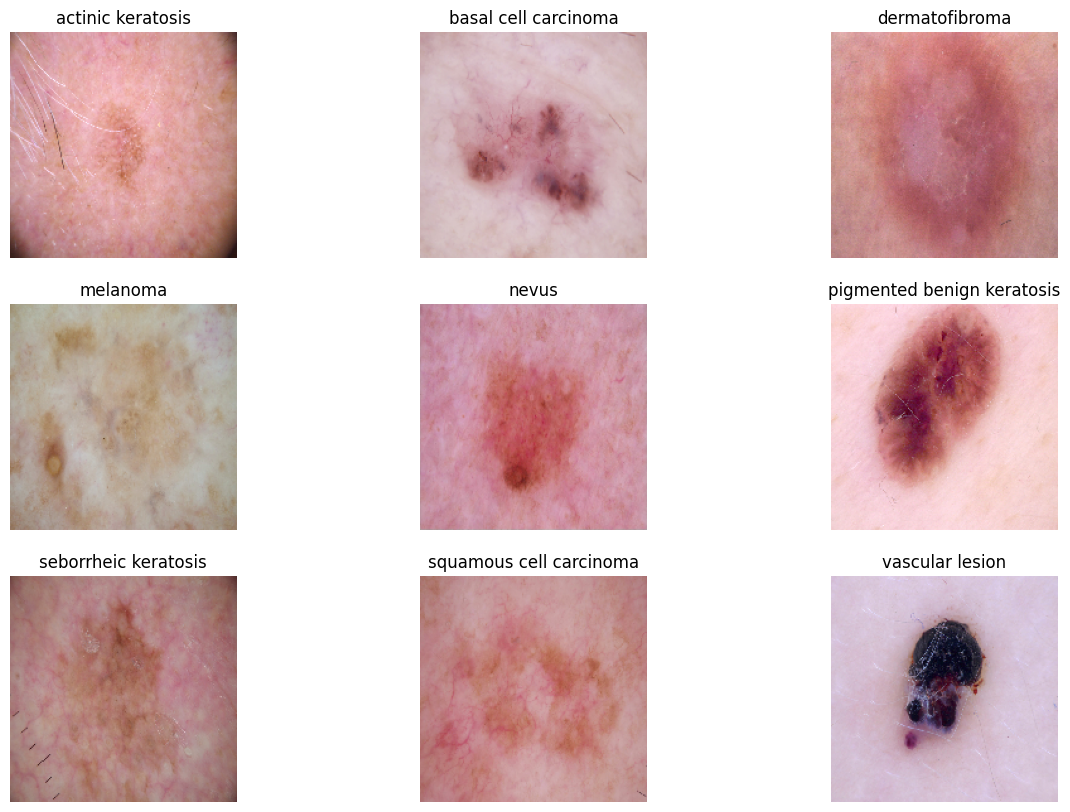

In [9]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img

### your code goes here, you can use training or validation data to visualize
images_per_class = {}

for c in class_names:
    images_per_class[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x, os.listdir(str(data_dir_train)+'/'+c)))

# Plot one image per class
plt.figure(figsize=(15, 10))
index = 0
for c in class_names:
    path_list = images_per_class[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

In [11]:
### Your code goes here
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    # layers.Conv2D(128, (3, 3), activation='relu'),
    # layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(9, activation='softmax')
])

/Users/sumapathy/miniforge3/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)

Epoch 1/20


2024-08-07 22:26:50.087215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


492/492 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.2661 - loss: 1.8937 - val_accuracy: 0.4068 - val_loss: 2.0755
Epoch 2/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - accuracy: 0.5234 - loss: 1.2625 - val_accuracy: 0.3898 - val_loss: 2.3889
Epoch 3/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 29s 59ms/step - accuracy: 0.6078 - loss: 1.0364 - val_accuracy: 0.4153 - val_loss: 3.1742
Epoch 4/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - accuracy: 0.6876 - loss: 0.8409 - val_accuracy: 0.4068 - val_loss: 3.4144
Epoch 5/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 29s 59ms/step - accuracy: 0.7299 - loss: 0.7324 - val_accuracy: 0.4153 - val_loss: 4.2597
Epoch 6/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 29s 59ms/step - accuracy: 0.7614 - loss: 0.6403 - val_accuracy: 0.3644 - val_loss: 5.4753
Epoch 7/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 29s 59ms/step - accuracy: 0.7871 - loss: 0.5551 - val_accuracy: 0.4153 - val_loss: 5.2443
Epoch 8/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 29s 59ms/step - accuracy: 0.8088 - loss: 0.5103 - val_accurac

### Visualizing training results

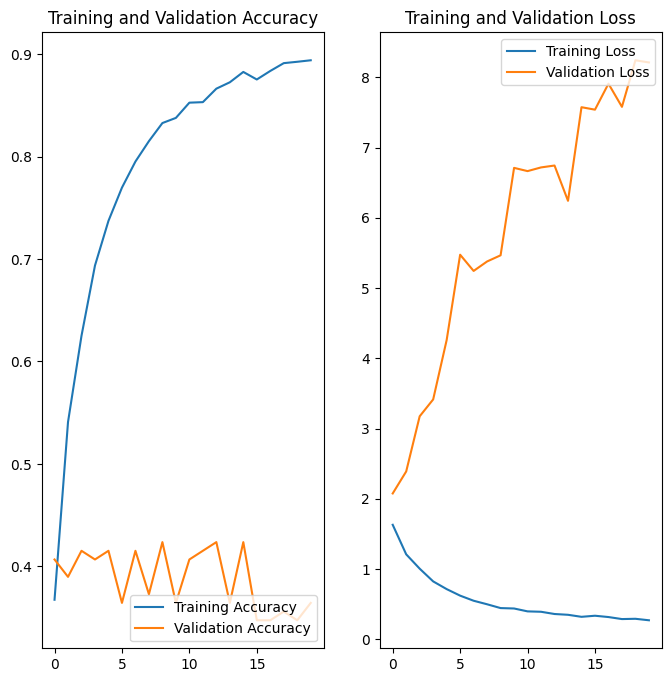

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

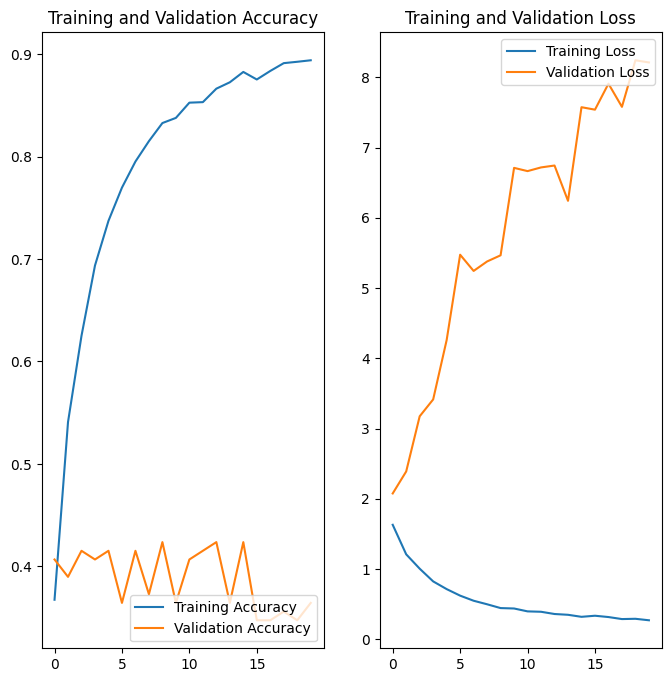

In [16]:

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

492/492 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9484 - loss: 0.1381
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3270 - loss: 7.6018
Accuracy:  0.9480271935462952
Validation Accuracy:  0.3644067943096161
Loss:  0.13745394349098206
Validation Loss 8.213273048400879


### Thus we can clearly see that model Overfit and we need to chose right data augumentation strategy

In [18]:
# after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

# Load training and validation datasets
train_ds = train_datagen.flow_from_directory(
    data_dir_train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    seed=123
)

val_ds = val_datagen.flow_from_directory(
    data_dir_test,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    seed=123
)

Found 15739 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


### Create the model, compile and train the model

In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

# Define the model
model = Sequential()

model.add(layers.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Compiling the model

In [20]:
# Compile the model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
# checkpoint = ModelCheckpoint("model.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

### Training the model

In [21]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    
)

Epoch 1/20


/Users/sumapathy/miniforge3/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


492/492 ━━━━━━━━━━━━━━━━━━━━ 85s 168ms/step - accuracy: 0.1266 - loss: 2.1965 - val_accuracy: 0.1356 - val_loss: 2.1837
Epoch 2/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 78s 156ms/step - accuracy: 0.1258 - loss: 2.1938 - val_accuracy: 0.1356 - val_loss: 2.1824
Epoch 3/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 79s 157ms/step - accuracy: 0.1216 - loss: 2.1935 - val_accuracy: 0.1356 - val_loss: 2.1849
Epoch 4/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 84s 169ms/step - accuracy: 0.1229 - loss: 2.1946 - val_accuracy: 0.1356 - val_loss: 2.1830
Epoch 5/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 84s 168ms/step - accuracy: 0.1186 - loss: 2.1938 - val_accuracy: 0.1356 - val_loss: 2.1833
Epoch 6/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 83s 167ms/step - accuracy: 0.1185 - loss: 2.1937 - val_accuracy: 0.1356 - val_loss: 2.1834
Epoch 7/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 83s 167ms/step - accuracy: 0.1205 - loss: 2.1945 - val_accuracy: 0.1356 - val_loss: 2.1818
Epoch 8/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 87s 175ms/step - accuracy: 0.1252 - loss: 2.1942 - val

### Visualizing the results

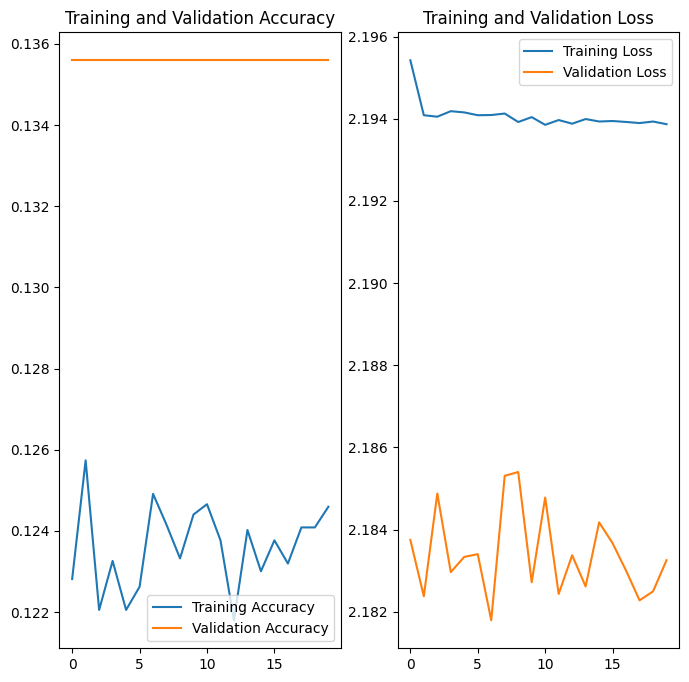

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### The model’s performance indicates no significant improvement and suggests the model might be underfitting. 

#### Find the distribution of classes in the training dataset.

Class: melanoma, Number of images: 439
Class: pigmented benign keratosis, Number of images: 463
Class: nevus, Number of images: 358
Class: basal cell carcinoma, Number of images: 377
Class: actinic keratosis, Number of images: 115
Class: squamous cell carcinoma, Number of images: 182
Class: vascular lesion, Number of images: 140
Class: seborrheic keratosis, Number of images: 78
Class: dermatofibroma, Number of images: 96


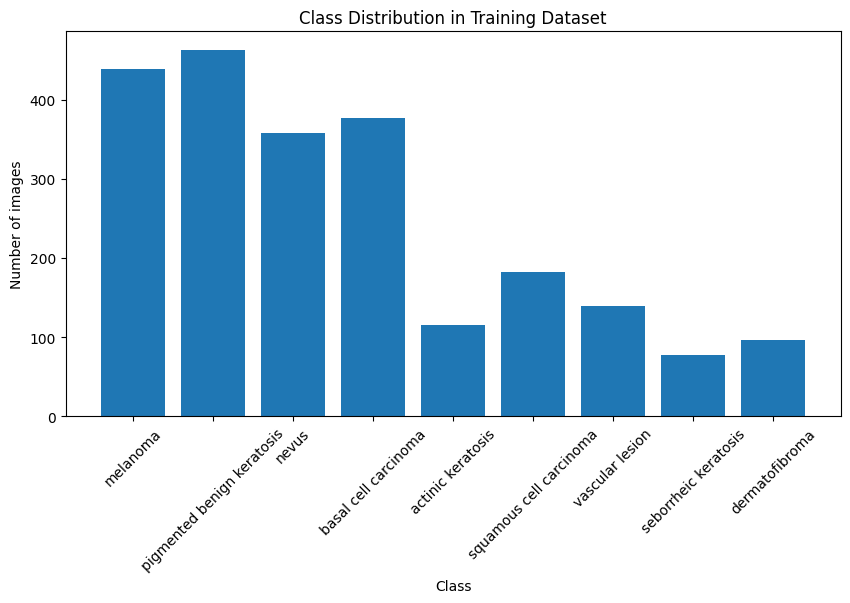

In [24]:
## Your code goes here.
# # Count the number of images per class in the training dataset
import os
import numpy as np

train_dir = data_dir_train
class_names = os.listdir(train_dir)
class_distribution = {}

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    class_count = len(os.listdir(class_path))
    class_distribution[class_name] = class_count

# Print the class distribution
for class_name, count in class_distribution.items():
    print(f"Class: {class_name}, Number of images: {count}")

# Optionally, visualize the class distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(class_distribution.keys(), class_distribution.values())
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Class Distribution in Training Dataset')
plt.xticks(rotation=45)
plt.show()

In [25]:
!pip3 install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [26]:
path_to_training_dataset="data/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 438 image(s) found.
Output directory set to data/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x315A950F0>: 100%|██████████| 500/500 [00:06<00:00, 77.76 Samples/s]  


Initialised with 462 image(s) found.
Output directory set to data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x315A76050>: 100%|██████████| 500/500 [00:01<00:00, 310.20 Samples/s]                  


Initialised with 357 image(s) found.
Output directory set to data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x315AB5DB0>: 100%|██████████| 500/500 [00:05<00:00, 86.42 Samples/s]                     


Initialised with 376 image(s) found.
Output directory set to data/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x315A6B700>: 100%|██████████| 500/500 [00:01<00:00, 342.09 Samples/s]


Initialised with 114 image(s) found.
Output directory set to data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x36A9DF3D0>: 100%|██████████| 500/500 [00:01<00:00, 318.75 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x315AD6650>: 100%|██████████| 500/500 [00:01<00:00, 355.16 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x315AB6980>: 100%|██████████| 500/500 [00:01<00:00, 344.03 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x315AD5AB0>: 100%|██████████| 500/500 [00:02<00:00, 186.48 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x36A9DF610>: 100%|██████████| 500/500 [00:01<00:00, 347.65 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [27]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

18000


In [28]:
import os
from glob import glob

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [29]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [30]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [31]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = (df2)

In [32]:
new_df['Label'].value_counts()

Label
melanoma                      2000
pigmented benign keratosis    2000
nevus                         2000
basal cell carcinoma          2000
actinic keratosis             2000
squamous cell carcinoma       2000
vascular lesion               2000
seborrheic keratosis          2000
dermatofibroma                2000
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [33]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [34]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)


Found 20239 files belonging to 9 classes.
Using 16192 files for training.


#### **Todo:** Create a validation dataset

In [35]:
# validation dataset 
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 20239 files belonging to 9 classes.
Using 4047 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [36]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [37]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

/Users/sumapathy/miniforge3/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [38]:
## your code goes here
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])
checkpoint = ModelCheckpoint("model.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

#### **Todo:**  Train your model

In [39]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 43s 64ms/step - accuracy: 0.2512 - loss: 1.9138 - val_accuracy: 0.4757 - val_loss: 1.4581
Epoch 2/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 39s 77ms/step - accuracy: 0.4730 - loss: 1.3781 - val_accuracy: 0.6017 - val_loss: 1.0972
Epoch 3/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 37s 73ms/step - accuracy: 0.5768 - loss: 1.1174 - val_accuracy: 0.5938 - val_loss: 1.0952
Epoch 4/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 39s 78ms/step - accuracy: 0.6314 - loss: 0.9515 - val_accuracy: 0.7373 - val_loss: 0.7527
Epoch 5/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 34s 67ms/step - accuracy: 0.6873 - loss: 0.8315 - val_accuracy: 0.8152 - val_loss: 0.5605
Epoch 6/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 40s 79ms/step - accuracy: 0.7601 - loss: 0.6281 - val_accuracy: 0.8307 - val_loss: 0.4804
Epoch 7/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 40s 78ms/step - accuracy: 0.8015 - loss: 0.5438 - val_accuracy: 0.8340 - val_loss: 0.4220
Epoch 8/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 42s 84ms/step - accuracy: 0.8180 - loss: 0.4940 - 

#### **Todo:**  Visualize the model results

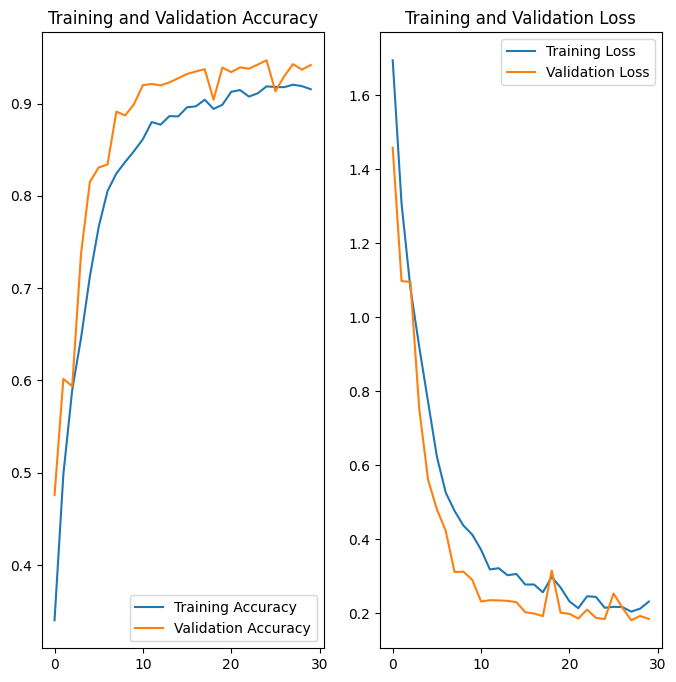

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analyzing your results here. To see if the underfitting/overfitting has been solved or not

In [41]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

506/506 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9599 - loss: 0.0976
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9396 - loss: 0.1859
Accuracy:  0.9588068127632141
Validation Accuracy:  0.9416851997375488
Loss:  0.10045400261878967
Validation Loss 0.18381942808628082


## The model’s performance has significantly improved, indicating that both underfitting and overfitting issues have been effectively mitigated.

## The class rebalance (through augmentation) has likely contributed to the improved performance, as the model now performs more consistently across classes.